### Import necessary pacakge

In [1]:
from swat import *
from pprint import pprint

import json
import sys

import dlpy
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.images import *
from dlpy.model import *
from dlpy.lr_scheduler import *
from dlpy.network import *

import cv2

### Connect to CAS

In [2]:
server_machine = 'your host machine'
server_port = 'your port number'
conn = CAS(server_machine, server_port)
conn.loadactionset('deepLearn')
conn.loadactionset('image')

NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'image'.


[actionset]

 'image'

+ Elapsed: 0.00152s, user: 0.000309s, sys: 0.0012s, mem: 0.22mb

### Objective
The objective of the task is to estimate keypoint positions on animal's footprint images. Essentially, we will formulate the problem as CNN based regression task.

Data:
    1. 224 * 224 color images of cropped animal footprint.
    2. 25 keypoints to describe a footprint.
    3. Each predicted keypoint is specified by an (x,y) pair normalized in range of -1 to 1.


### Load training dataset
The data is sourced from a WildTrack project in which SAS incorporated with WildTrack organization over footprint identification techinque(FIT). 

In [3]:
data_path = 'your/data/path'
data_caslib, data_file_name, _ = caslibify(conn=conn, path=data_path, task='load')
conn.loadtable(caslib=data_caslib, path=data_file_name,
            casout=dict(name='landmark', replace=1), where='nl_x24 ne .')

NOTE: Cloud Analytic Services made the file wildtrack_species_landmarks.sashdat available as table LANDMARK in caslib CASUSER().


[caslib]

 'CASUSER()'

[tableName]

 'LANDMARK'

[casTable]

 CASTable('LANDMARK', caslib='CASUSER()')

+ Elapsed: 0.855s, user: 0.258s, sys: 0.594s, mem: 71.8mb

### Preprocess dataset
Let's cast the table as DLPy ImageTable type.

In [5]:
# Last 50 variables in dataset are target variables.
targets = list(conn.columninfo('landmark').ColumnInfo.Column.values[-50:])
dataset = ImageTable.from_table(label_col='species', tbl=conn.CASTable('landmark'), columns=targets)

Resize all images and split the whole dataset into training and testing dataset.

In [6]:
dataset.resize(224, columns=targets)
trainset, testset = two_way_split(tbl=dataset, test_rate=10, im_table=False, stratify=False)

### Build CNN model
Next, let's build a CNN model comprised of convolution layer, pooling layer and keypoints layer. The backbone of the model is ResNet18. The model ends up with a Keypoints layer which is responsible for calculating regression error and back-propagating gradients. Keypoints layer allows you to specify error function and number of neurons. In the case, n(number of neurons) is set as 50 because there will be at most 25 landmarks on each image and each of landmarks requires two value, x and y, to describe the location. 

In [7]:
dummy_class_number = 2
resnet18_model = ResNet18_Caffe(conn, n_classes=dummy_class_number, random_crop='none', random_mutation='RANDOM')

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [8]:
resnet18_backbone = resnet18_model.to_functional_model(stop_layers=resnet18_model.layers[-1])

In [9]:
input_ = Input(**resnet18_backbone.layers[0].config, name='input') # input tensor
resnet18_backbone_out = resnet18_backbone(input_) # keypoints feature

In [10]:
keypoints_layer = Keypoints(n=50, name='kp1') # keypoints layers
keypoints_out = keypoints_layer(resnet18_backbone_out) # head of the model

In [11]:
# build the model using Functional API
keypoints_model = Model(conn, inputs=input_, outputs=keypoints_out, model_table='keypoints_model')
keypoints_model.compile()

NOTE: Model compiled successfully.


### Plot network
To enable graphic visualizations of DLPy deep learning models, it is recommended that you download and install the open source graph visualization software called Graphviz. <br>
Graphviz is available at https://www.graphviz.org/download/.

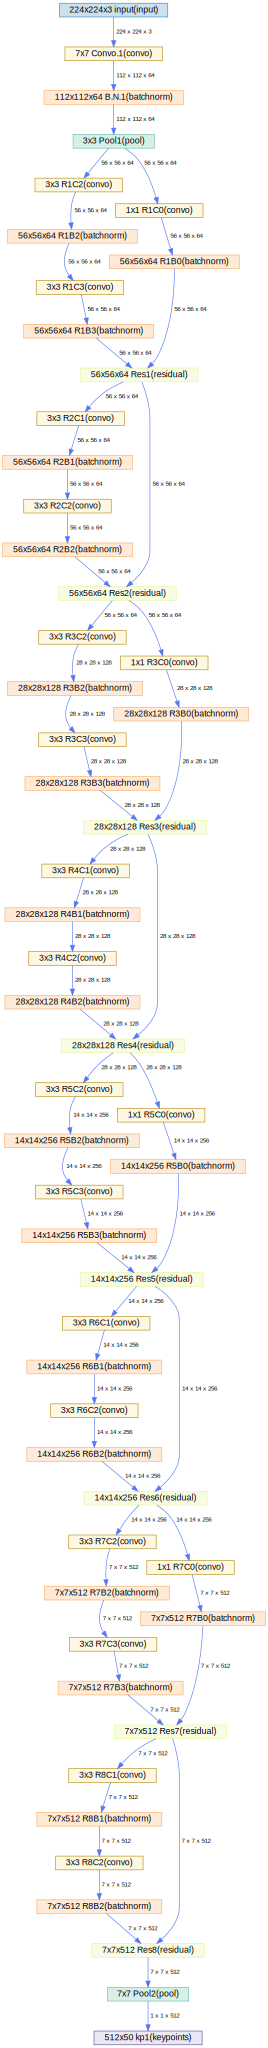

In [12]:
keypoints_model.plot_network()

### Load pre-trained weights if available

In [13]:
initial_weights_path = 'path_to_your_initial_weights'
initial_weights_caslib, initial_weights_file_name, _ = caslibify(conn=conn, path=initial_weights_path, task='load')

conn.loadtable(caslib = initial_weights_caslib, path=initial_weights_file_name,
               casout=dict(name='initial_weights', replace=1))

if conn.table.tableexists(name='initial_weights').exists:
    keypoints_model.set_weights('initial_weights')

NOTE: Cloud Analytic Services made the file RESNET18_CAFFE_weights.sashdat available as table INITIAL_WEIGHTS in caslib CASUSER().
NOTE: Model weights attached successfully!


### Train model

In [14]:
optimizer = Optimizer(mini_batch_size=12, log_level=2, max_epochs=10, reg_l2=0.0005,
                      algorithm=MomentumSolver(clip_grad_max=100, clip_grad_min=-100,
                                               learning_rate=0.000001, step_size=30))
data_specs = [DataSpec(type_='IMAGE', layer='input', data=['_image_']),
              DataSpec(type_='numnom', layer='kp1', data=targets)]
keypoints_model.fit(data=trainset, optimizer=optimizer,
                    # specify data type of input and output layers
                    data_specs=data_specs,
                    gpu=dict(devices=0),
                    n_threads = 5)

NOTE: Training based on existing weights.
NOTE: Using dlgrd009.unx.sas.com: 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 11206386.
NOTE:  The approximate memory cost is 279.00 MB.
NOTE:  Loading weights cost       0.07 (s).
NOTE:  Initializing each layer cost       2.09 (s).
NOTE:  The total number of threads on each worker is 5.
NOTE:  The total mini-batch size per thread on each worker is 12.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 60.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          1E-6           153.9      307.7     2.24
NOTE:  1          1E-6             131      262.1     0.49
NOTE:  2          1E-6           105.1      210.2     0.49
NOTE:  3          1E-6           82.87      165.7     0.49
NOTE:  4          1E-6           65.95      131.9     0.49
NOTE: 

,Descr,Value
0,Model Name,keypoints_model
1,Model Type,Convolutional Neural Network
2,Number of Layers,54
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,21
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,21
9,Number of Residual Layers,8


### Get predictions

In [15]:
keypoints_model.predict(data=testset)

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            68
 1  Number of Observations Used            68
 2           Mean Squared Error      51.02471
 3                   Loss Error      25.51236

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER()  Valid_Res_8EWrzJ    68      103   
 
                                             casTable  
 0  CASTable('Valid_Res_8EWrzJ', caslib='CASUSER(w...  

+ Elapsed: 0.908s, user: 11.4s, sys: 5.91s, mem: 3.01e+03mb

### Visualize predictions
Here, we define a helper function to plot predictions.

In [16]:
def plot_landmarks(conn, data, targets, image_list=range(4), n_col=2, figsize=None):
    import cv2
    targets.sort(key=lambda x: int(x[max(x.find('x'), x.find('y')) + 1:]))
    n_images = len(image_list)
    num_obs = min(conn.numrows(data)['numrows'], n_images)
    res_img = conn.fetchimages(table=data, to=num_obs).Images
    res_label = conn.fetch(data, fetchvars=targets, to=num_obs).Fetch

    if n_images > n_col:
        n_row = n_images // n_col + 1
    else:
        n_row = 1
        n_col = n_images

    if figsize is None:
        figsize = (16, 16 // n_col * n_row)

    fig = plt.figure(figsize=figsize)

    idx_img = 1
    for i in image_list:
        img = res_img.loc[i, 'Image']
        img_arr = np.array(img)
        circle_size = int(min(img_arr.shape[:2])/40)
        for k in range(0, len(targets), 2):
            x = int(res_label.loc[i, targets[k]] * res_img.loc[i, 'Width'] / 2 + res_img.loc[i, 'Width'] / 2)
            y = int(res_label.loc[i, targets[k + 1]] * res_img.loc[i, 'Height'] / 2 + res_img.loc[i, 'Height'] / 2)
            cv2.circle(img_arr, (x, y), circle_size, (255, 0, 0), -1)
        ax = fig.add_subplot(n_row, n_col, idx_img)
        plt.imshow(img_arr, cmap='gray')
        # plt.title (str(r['Images']['_path_'].loc[i].split('.')[0]))
        idx_img = idx_img + 1
        plt.xticks([]), plt.yticks([])
    plt.show()

NOTE: Table VALID_RES_8EWRZJ contains compressed images.


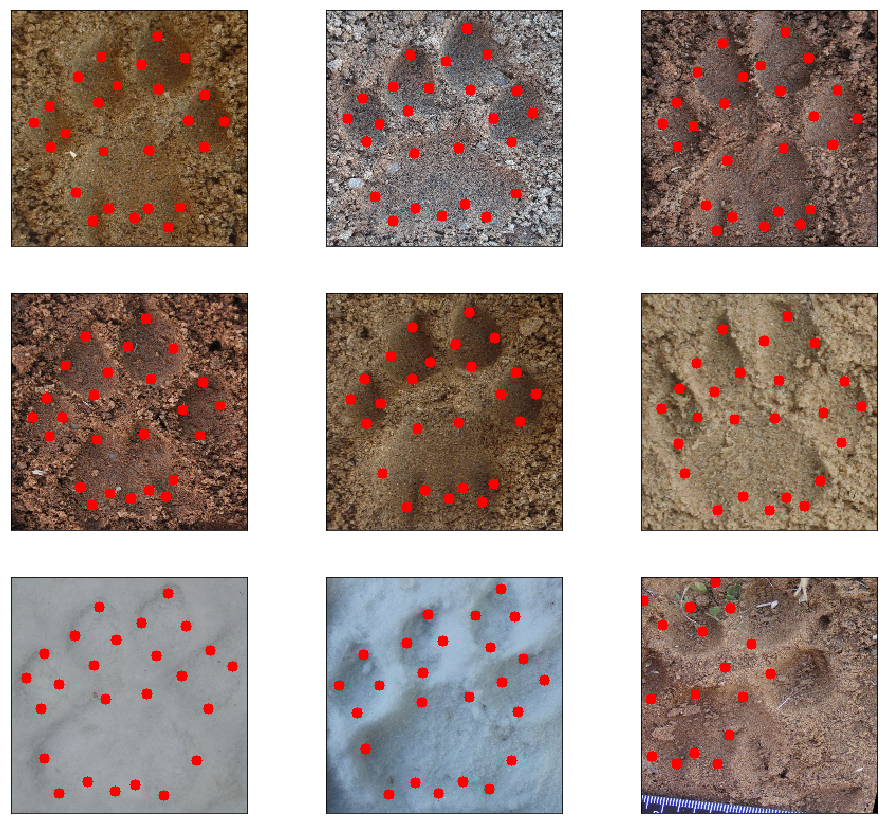

In [17]:
plot_landmarks(conn, keypoints_model.valid_res_tbl, targets=targets, image_list=range(9), n_col=3)

### More applications of keypoint detection
Keypoint detection can be applied on fashion. Alibaba launched FashionAI competition this years. The competition concentrates on the key point localization of women apparel.

Besides, keypoint layer can be used to solve any multiple interval target regression problems.

In [69]:
conn.endsession()

+ Elapsed: 0.000189s, user: 0.000142s, sys: 2.9e-05s, mem: 0.221mb